<a href="https://colab.research.google.com/github/llaser00/Tests/blob/main/run_on_idc_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Run AI segmentation on the TCGA-LIHC collection.

Be sure to run this in a runtime with an attached GPU


Querying and Download the CT scans is based on the [IDC  tutorial cookbook](https://github.com/ImagingDataCommons/IDC-Tutorials/blob/master/notebooks/cookbook.ipynb).

## Prerequisites
Please complete the prerequisites as described in this [documentation page](https://learn.canceridc.dev/introduction/getting-started-with-gcp).

Insert that project ID in the cell below.

In [1]:
#@title Enter your Project ID and authenticate with GCP
# initialize this variable with your Google Cloud Project ID!
my_ProjectID = 'test-project-160126'

import os
os.environ["GCP_PROJECT_ID"] = my_ProjectID

from google.colab import auth
auth.authenticate_user()

import pandas as pd
import subprocess
from pathlib import Path
from tempfile import TemporaryDirectory
import shutil
from tqdm.auto import tqdm

Install the `s5cmd` tool for efficient manifest downloads

In [2]:
%%shell
VERSION="s5cmd_2.2.2_Linux-64bit"
wget https://github.com/peak/s5cmd/releases/download/v2.2.2/${VERSION}.tar.gz
tar zxf ${VERSION}.tar.gz
mv s5cmd /usr/bin

--2026-02-08 09:44:29--  https://github.com/peak/s5cmd/releases/download/v2.2.2/s5cmd_2.2.2_Linux-64bit.tar.gz
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/73909333/e095ae85-9acf-4dcc-b744-128b3311849c?sp=r&sv=2018-11-09&sr=b&spr=https&se=2026-02-08T10%3A28%3A06Z&rscd=attachment%3B+filename%3Ds5cmd_2.2.2_Linux-64bit.tar.gz&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2026-02-08T09%3A27%3A26Z&ske=2026-02-08T10%3A28%3A06Z&sks=b&skv=2018-11-09&sig=WmIAYDFCNKRxdmg6bPz%2BWZyI%2FYCPycZJrE6tFu%2BWBuI%3D&jwt=eyJ0eXAiOiJKV1QiLCJhbGciOiJIUzI1NiJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmVsZWFzZS1hc3NldHMuZ2l0aHVidXNlcmNvbnRlbnQuY29tIiwia2V5Ijoia2V5MSIsImV4cCI6MTc3MDU0NDE3MCwibmJmIjoxNzcwNTQzODcwLCJwYXRoIjoicmVsZWFz

Install dcm2niix for dicom conversion. Use the prebuild version because it was jpeg support.

In [3]:
%%shell
curl -fLO https://github.com/rordenlab/dcm2niix/releases/latest/download/dcm2niix_lnx.zip
unzip -o dcm2niix_lnx.zip -d /usr/bin

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  866k  100  866k    0     0  1708k      0 --:--:-- --:--:-- --:--:-- 1708k
Archive:  dcm2niix_lnx.zip
  inflating: /usr/bin/dcm2niix       


We can build a download manifest. To reproduce our results, get a list of the SeriesInstanceUIDs from the `qa-results.csv` file. This csv is in the liver-ct.zip file at https://zenodo.org/record/8352041. Alternativly, we can get a copy directly from the github repo

In [4]:
%%shell
wget https://github.com/bamf-health/aimi-liver-ct/raw/main/qa-results/qa-results.csv

--2026-02-08 09:44:31--  https://github.com/bamf-health/aimi-liver-ct/raw/main/qa-results/qa-results.csv
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/bamf-health/aimi-liver-ct/main/qa-results/qa-results.csv [following]
--2026-02-08 09:44:31--  https://raw.githubusercontent.com/bamf-health/aimi-liver-ct/main/qa-results/qa-results.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30110 (29K) [text/plain]
Saving to: ‘qa-results.csv’

qa-results.csv      100%[===================>]  29.40K  --.-KB/s    in 0.003s  

2026-02-08 09:44:31 (9.29 MB/s) - ‘qa-results.csv’ saved [30110/30110]



In [5]:
qa_df = pd.read_csv('qa-results.csv')
series_uids = qa_df.SeriesInstanceUID.tolist()

In [6]:
# python API is the most flexible way to query IDC BigQuery metadata tables
!pip install google-cloud-bigquery
!pip install db-dtypes
import db_dtypes # Explicitly import db_dtypes
from google.cloud import bigquery
bq_client = bigquery.Client(my_ProjectID)

# The series_uids are already correctly formatted as single-quoted strings
# from the qa_df.SeriesInstanceUID.tolist() step, based on the current kernel state.
# Removing the line below to avoid double-quoting.
series_uids = [f"'{x}'" for x in series_uids]

selection_query =f"""
SELECT
  # Organize the files in-place right after downloading
  ANY_VALUE(CONCAT("cp s3",REGEXP_SUBSTR(gcs_url, "(://.*)/"),"/* ",collection_id,"/",PatientID,"/",StudyInstanceUID,"/",SeriesInstanceUID)) AS s5cmd_command
FROM
  `bigquery-public-data.idc_current.dicom_all`
WHERE
  SeriesInstanceUID IN ({','.join(series_uids)})
GROUP BY
  SeriesInstanceUID
"""

selection_result = bq_client.query(selection_query)
selection_df = selection_result.result().to_dataframe()

selection_df.to_csv("/content/s5cmd_gcp_manifest.txt", header=False, index=False)

Download manifest with the `s5cmd` tool.

In [7]:
%%shell
# check if dicoms have already been downloaded
if test -n "$(find dcms -name '*.dcm' -print -quit)"
then
    echo "dicoms already downloaded"
else
  mkdir -p dcms
  cd dcms && s5cmd --no-sign-request --endpoint-url https://storage.googleapis.com run ../s5cmd_gcp_manifest.txt
  cd -
fi

Streaming output truncated to the last 5000 lines.
cp s3://idc-open-data/b700e5bc-248b-40e2-a946-ad2a3aa62746/7c9fea16-1339-4ae5-91b8-7ca024e2dee1.dcm tcga_lihc/TCGA-DD-A4NN/1.3.6.1.4.1.14519.5.2.1.3344.4008.238875024531656123348758022775/1.3.6.1.4.1.14519.5.2.1.3344.4008.207848934776528286087485176422/7c9fea16-1339-4ae5-91b8-7ca024e2dee1.dcm
cp s3://idc-open-data/fe889f59-263e-430f-bdb2-31de9f884b9c/c1a0f10a-2091-42a8-8780-006208c320e6.dcm tcga_lihc/TCGA-DD-A4NO/1.3.6.1.4.1.14519.5.2.1.3344.4008.759986268611549722078244299409/1.3.6.1.4.1.14519.5.2.1.3344.4008.479401360926084327281964656390/c1a0f10a-2091-42a8-8780-006208c320e6.dcm
cp s3://idc-open-data/40dc569b-8f42-4619-9663-199c479f6942/e3929c48-6ebe-4a69-8fb9-bc7ae67599b3.dcm tcga_lihc/TCGA-DD-A115/1.3.6.1.4.1.14519.5.2.1.3344.4008.111190381797398190611685670115/1.3.6.1.4.1.14519.5.2.1.3344.4008.161980713684483394055711266086/e3929c48-6ebe-4a69-8fb9-bc7ae67599b3.dcm
cp s3://idc-open-data/02ecdd29-b7af-4f92-a989-64ec42a6c9f0/b81dfa2c

# Run model on TCGA-LIHC
You can run the model on the downloaded scans with the below code.

>If you want to run the model locally, this code is containerized in the project. Refer to the [readme](https://github.com/bamf-health/aimi-liver-ct/tree/main#running-inference) for instructions on running the container locally.

Install `nnunet` python package

In [17]:
%%capture
!pip install nnunet

In [18]:
# setup nnunet paths
os.environ["nnUNet_raw_data_base"] ="/nnunet_data/nnUNet_raw_data_base/"
os.environ["nnUNet_preprocessed"] ="/nnunet_data/nnUNet_preprocessed/"
os.environ["RESULTS_FOLDER"] ="/nnunet_data/nnUNet_trained_models/"


download model weights from zenodo

In [10]:
%%shell
# check if weights exist before starting a large downloaded
if [ ! -f ${RESULTS_FOLDER}nnUNet/3d_fullres/Task773_Liver/nnUNetTrainerV2__nnUNetPlansv2.1/fold_0/model_final_checkpoint.model ]
then
    mkdir -p ${nnUNet_raw_data_base}
    mkdir -p ${nnUNet_preprocessed}
    mkdir -p ${RESULTS_FOLDER}nnUNet/
    echo "Downloading model weights"
    wget https://zenodo.org/record/8274976/files/Task773_Liver.zip
    unzip Task773_Liver.zip -d ${RESULTS_FOLDER}nnUNet/
else
    echo "model weights already downloaded"
fi

--2026-02-08 09:45:42--  https://zenodo.org/record/8274976/files/Task773_Liver.zip
Resolving zenodo.org (zenodo.org)... 188.185.48.75, 137.138.52.235, 188.184.103.118, ...
Connecting to zenodo.org (zenodo.org)|188.185.48.75|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/8274976/files/Task773_Liver.zip [following]
--2026-02-08 09:45:43--  https://zenodo.org/records/8274976/files/Task773_Liver.zip
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 1166314033 (1.1G) [application/octet-stream]
Saving to: ‘Task773_Liver.zip’

Task773_Liver.zip   100%[===================>]   1.09G  10.4MB/s    in 14m 46s 

2026-02-08 10:00:29 (1.25 MB/s) - ‘Task773_Liver.zip’ saved [1166314033/1166314033]

Archive:  Task773_Liver.zip
   creating: /nnunet_data/nnUNet_trained_models/nnUNet/3d_fullres/
   creating: /nnunet_data/nnUNet_trained_models/nnUNet/3d_fullres/Task773_Liver/
   creating: /nnunet_data/n

Install binaries for `itkimage2segimage` executable

In [11]:
%%shell
# Install binaries for itkimage2segimage package
mkdir -p /app
PACKAGE_TAR="dcmqi-1.2.5-linux.tar.gz"
ITKIMAGE2SEGIMAGE_URL=https://github.com/QIICR/dcmqi/releases/download/v1.2.5/${PACKAGE_TAR}
wget ${ITKIMAGE2SEGIMAGE_URL} --no-check-certificate
tar -zxvf ${PACKAGE_TAR} -C /app
rm ${PACKAGE_TAR}

--2026-02-08 10:00:47--  https://github.com/QIICR/dcmqi/releases/download/v1.2.5/dcmqi-1.2.5-linux.tar.gz
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/50675718/79d3ad95-9f0c-42a4-a1c5-bf5a63461894?sp=r&sv=2018-11-09&sr=b&spr=https&se=2026-02-08T10%3A36%3A00Z&rscd=attachment%3B+filename%3Ddcmqi-1.2.5-linux.tar.gz&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2026-02-08T09%3A35%3A14Z&ske=2026-02-08T10%3A36%3A00Z&sks=b&skv=2018-11-09&sig=pgk3qBppcxsPSKreC2uPHIMUK7USH%2BYJihaJgeGrwAE%3D&jwt=eyJ0eXAiOiJKV1QiLCJhbGciOiJIUzI1NiJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmVsZWFzZS1hc3NldHMuZ2l0aHVidXNlcmNvbnRlbnQuY29tIiwia2V5Ijoia2V5MSIsImV4cCI6MTc3MDU0NjY0NywibmJmIjoxNzcwNTQ0ODQ3LCJwYXRoIjoicmVsZWFzZWFzc2V0cHJvZHV

Run inference on scans.

First download  `run.py` and `ai-dicom-seg-meta.json` from the git repo

In [12]:
%%shell
wget https://github.com/bamf-health/aimi-liver-ct/raw/main/container/app/src/run.py
wget https://github.com/bamf-health/aimi-liver-ct/raw/main/container/app/dcm-meta/ai-dicom-seg-meta.json

--2026-02-08 10:00:49--  https://github.com/bamf-health/aimi-liver-ct/raw/main/container/app/src/run.py
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/bamf-health/aimi-liver-ct/main/container/app/src/run.py [following]
--2026-02-08 10:00:49--  https://raw.githubusercontent.com/bamf-health/aimi-liver-ct/main/container/app/src/run.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7429 (7.3K) [text/plain]
Saving to: ‘run.py’

run.py              100%[===================>]   7.25K  --.-KB/s    in 0s      

2026-02-08 10:00:49 (63.1 MB/s) - ‘run.py’ saved [7429/7429]

--2026-02-08 10:00:49--  https

Then run model on all downloaded dicom series

In [13]:
!rm -rf preds

In [19]:
import torch
import torch.serialization

# This forces the old loading behavior (Pre-PyTorch 2.6)
# Only do this because we trust the MIC-DKFZ model source!
def trust_all_weights():
    old_load = torch.load
    def new_load(*args, **kwargs):
        kwargs['weights_only'] = False
        return old_load(*args, **kwargs)
    torch.load = new_load

trust_all_weights()
print("Global weights_only check disabled.")

Global weights_only check disabled.


In [56]:
import os
from pathlib import Path

# Find image folder
# Find the first dicom file and take its parent directory
root_dcm_path = Path('/content/dcms/tcga_lihc/TCGA-BC-A10Z/')
try:
    actual_image_folder = next(root_dcm_path.rglob('*.dcm')).parent
    print(f"Found files deep inside: {actual_image_folder}")
except StopIteration:
    print("ERROR: No .dcm files found at all!")

# Prepare output path
!rm -rf /content/nnunet_input
os.makedirs("/content/nnunet_input", exist_ok=True)

# Convert dicom files to nifti
!dcm2niix -z y -f "test_scan_0000" -o /content/nnunet_input "{actual_image_folder}"

Found files deep inside: /content/dcms/tcga_lihc/TCGA-BC-A10Z/1.3.6.1.4.1.14519.5.2.1.8421.4008.338750756821159002165351451130/1.3.6.1.4.1.14519.5.2.1.8421.4008.761093011533106086639756339870
Chris Rorden's dcm2niiX version v1.0.20250505  (JP2:OpenJPEG) (JP-LS:CharLS) GCC8.4.0 x86-64 (64-bit Linux)
Found 78 DICOM file(s)
Convert 78 DICOM as /content/nnunet_input/test_scan_0000 (512x512x78x1)
Compress: "/usr/bin/pigz" -b 960 --no-time -n -f -6 "/content/nnunet_input/test_scan_0000.nii"
Conversion required 2.743441 seconds (0.151927 for core code).


In [21]:
import torch
import os
from nnunet.inference.predict_simple import main as nnunet_main
import sys

# Disable the security check in the current process
import torch.serialization
torch.serialization.add_safe_globals(['numpy.core.multiarray.scalar', 'numpy.dtype', 'numpy._core.multiarray.scalar'])

# Set the environment variable for the internal logic
os.environ["RESULTS_FOLDER"] = "/nnunet_data/nnUNet_trained_models/"
os.environ["TORCH_FORCE_WEIGHTS_ONLY_LOAD"] = "0"

# Manually simulate the command line arguments
sys.argv = [
    "nnUNet_predict",
    "-i", "/content/nnunet_input",
    "-o", "/content/preds",
    "-t", "773",
    "-m", "3d_fullres",
    "-f", "0"
]

# Run the function directly in Python (so it inherits our 'add_safe_globals')
print("Starting prediction via Python entry point...")
nnunet_main()



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

Starting prediction via Python entry point...
using model stored in  /nnunet_data/nnUNet_trained_models/nnUNet/3d_fullres/Task773_Liver/nnUNetTrainerV2__nnUNetPlansv2.1
This model expects 1 input modalities for each image
Found 1 unique case ids, here are some examples: ['test_scan']
If they don't look right, make sure to double check your filenames. They must end with _0000.nii.gz etc
number of cases: 1
number of cases that still need to be predicted: 1
emptying cuda cache
loading parameters for folds, [0]
using the following model files:  ['/nnunet_data/nnUNet_trained_models/nnUNet/3d_fullres/Task773_Liver/nnUNetTrainerV2__nnUNe

/usr/local/lib/python3.12/dist-packages/nnunet/training/network_training/network_trainer.py:404: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.amp_grad_scaler = GradScaler()
/usr/local/lib/python3.12/dist-packages/torch/cuda/amp/grad_scaler.py:31: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  super().__init__(
/usr/local/lib/python3.12/dist-packages/nnunet/network_architecture/neural_network.py:141: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with context():
/usr/local/lib/python3.12/dist-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


done
prediction done
inference done. Now waiting for the segmentation export to finish...
force_separate_z: None interpolation order: 1
separate z: True lowres axis [0]
separate z, order in z is 0 order inplane is 1
WARNING! Cannot run postprocessing because the postprocessing file is missing. Make sure to run consolidate_folds in the output folder of the model first!
The folder you need to run this in is /nnunet_data/nnUNet_trained_models/nnUNet/3d_fullres/Task773_Liver/nnUNetTrainerV2__nnUNetPlansv2.1


In [57]:
import os
output_path = "/content/preds/test_scan.nii.gz"

if os.path.exists(output_path):
    print(f"Success! Prediction found at {output_path}")
    print(f"File size: {os.path.getsize(output_path) / 1024 / 1024:.2f} MB")
else:
    print("The file wasn't saved. We might need to check the output folder permissions.")

Success! Prediction found at /content/preds/test_scan.nii.gz
File size: 0.05 MB


In [28]:
!pip install "pydicom<3.0.0" "pydicom-seg" "SimpleITK"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 19.6 MB/s eta 0:00:00
  Attempting uninstall: pydicom
    Found existing installation: pydicom 3.0.1
    Uninstalling pydicom-3.0.1:
      Successfully uninstalled pydicom-3.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dicom2nifti 2.6.2 requires pydicom>=3.0.0, but you have pydicom 2.4.4 which is incompatible.


In [58]:
import pydicom

# Check if the missing module is actually there
if not hasattr(pydicom, '_storage_sopclass_uids'):
    # We manually link the new location to the old name the library expects
    import pydicom._storage_sopclass_uids as uids
    pydicom._storage_sopclass_uids = uids
    print("Bridge created for pydicom SOP Class UIDs!")

In [55]:
import pydicom_seg
import SimpleITK as sitk
import json
from pathlib import Path

# --- INPUT PATHS ---
nifti_input = Path("/content/preds/test_scan.nii.gz")
metadata_path = "/content/ai-dicom-seg-meta.json"
# The top-level folder
root_dcm_path = Path('/content/dcms/tcga_lihc/TCGA-BC-A10Z/')

# Find the dicom folder
try:
    actual_image_folder = next(root_dcm_path.rglob('*.dcm')).parent
    print(f"Original DICOMs found in: {actual_image_folder}")
except StopIteration:
    print("ERROR: No .dcm files found!")
    actual_image_folder = None

if actual_image_folder and nifti_input.exists():
    # Load Metadata Template (json file)
    with open(metadata_path, 'r') as f:
        template = json.load(f)
    template_loader = pydicom_seg.template.from_dcmqi_metainfo(template)

    # Load the AI Prediction - the nifti file created before
    segmentation_image = sitk.ReadImage(str(nifti_input))

    # Load the dicom Series
    print("Reading DICOM series metadata...")
    series_ids = sitk.ImageSeriesReader.GetGDCMSeriesIDs(str(actual_image_folder))
    if not series_ids:
      raise ValueError(f"No DICOM series found in {actual_image_folder}")

    # Get the file names for the first series found
    series_file_names = sitk.ImageSeriesReader.GetGDCMSeriesFileNames(
      str(actual_image_folder), series_ids[0]
)

    # Load the actual dicom slices as a list of pydicom objects
    source_images = [pydicom.dcmread(x) for x in series_file_names]

    writer = pydicom_seg.MultiClassWriter(
      template=template_loader
      )

try:
    print("Building DICOM-SEG object...")
    # This combines the NIfTI voxels with the DICOM headers
    dcm_seg = writer.write(segmentation_image, source_images)

    output_name = f"/content/{root_dcm_path.name}_SEG.dcm"
    dcm_seg.save_as(output_name)
    print(f"SUCCESS! DICOM-SEG saved as: {output_name}")
except Exception as e:
    print(f"CONVERSION ERROR: {e}")

Original DICOMs found in: /content/dcms/tcga_lihc/TCGA-BC-A10Z/1.3.6.1.4.1.14519.5.2.1.8421.4008.338750756821159002165351451130/1.3.6.1.4.1.14519.5.2.1.8421.4008.761093011533106086639756339870
Reading DICOM series metadata...
Building DICOM-SEG object...
SUCCESS! DICOM-SEG saved as: /content/TCGA-BC-A10Z_SEG.dcm


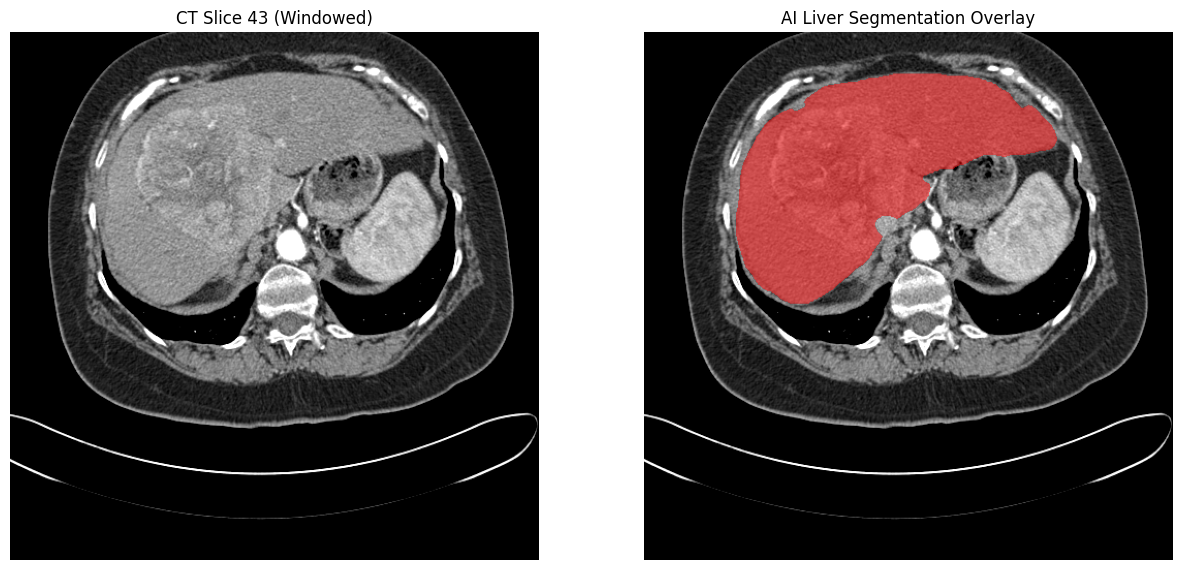

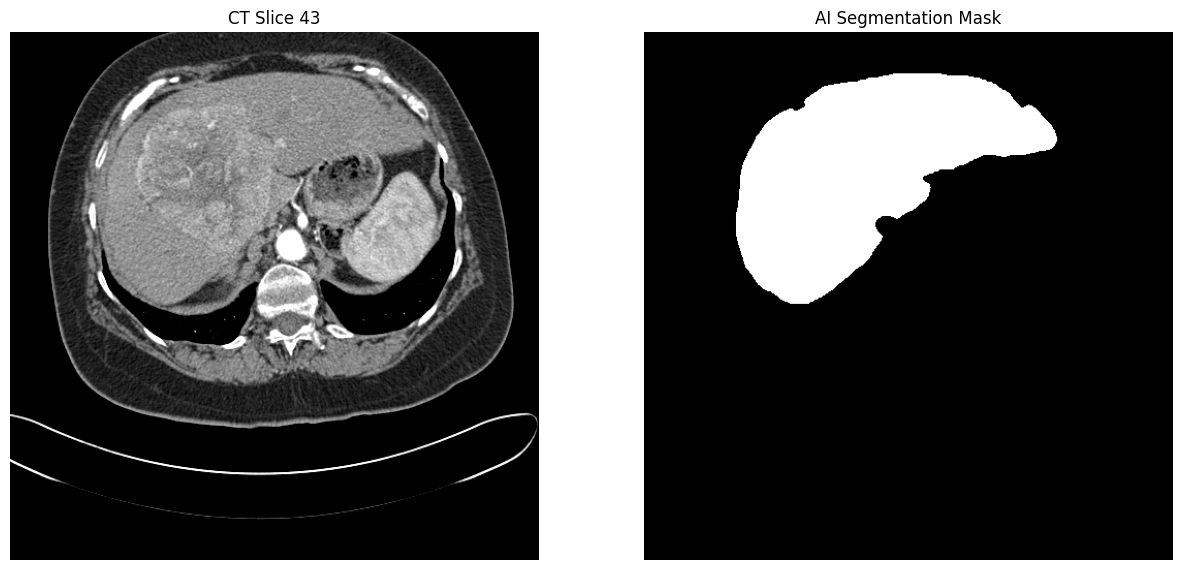

Slice index shown: 43
Max value in CT slice: 240.0
Max value in Mask slice: 1.0


In [39]:
%matplotlib inline
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np

# 1. Load the data
img_nifti = nib.load('/content/nnunet_input/test_scan_0000.nii.gz')
mask_nifti = nib.load('/content/preds/test_scan.nii.gz')

img = img_nifti.get_fdata()
mask = mask_nifti.get_fdata()

# 2. Pick a slice that we KNOW has data (finding the slice with max mask pixels)
z_slice = np.argmax(np.sum(mask, axis=(0, 1)))

# 3. Simple Windowing (Soft Tissue Window)
# CT values: -160 to 240 is a good range for the liver
img_slice = img[:, :, z_slice].T
img_slice = np.clip(img_slice, -160, 240)

# 4. Create the plot
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

# Left: The Original Scan
ax[0].imshow(img_slice, cmap='gray', origin='lower')
ax[0].set_title(f"CT Slice {z_slice}")
ax[0].axis('off')

# Right: The Binary Mask (Should be Black and White)
ax[1].imshow(mask[:, :, z_slice].T, cmap='gray', origin='lower')
ax[1].set_title("AI Segmentation Mask")
ax[1].axis('off')

plt.show()

# Data Debug Check
print(f"Slice index shown: {z_slice}")
print(f"Max value in CT slice: {np.max(img_slice)}")
print(f"Max value in Mask slice: {np.max(mask[:, :, z_slice])}")

In [41]:
!pip install dicom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 766.3/766.3 kB 10.2 MB/s eta 0:00:00


Visualizing the dicom seg file

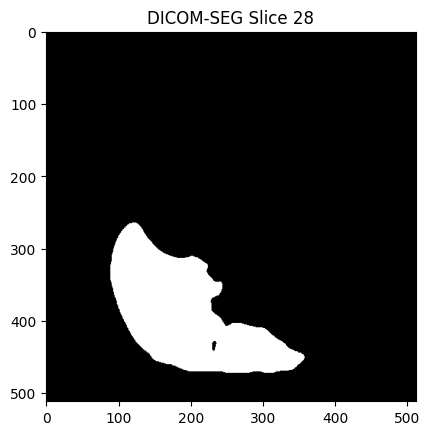

In [53]:
# Full path of the DICOM file is passed in base
base = r"/content/"
pass_dicom = "TCGA-BC-A10Z_SEG.dcm"

# enter DICOM image name for pattern
# result is a list of 1 element
filename = pydicom.data.data_manager.get_files(base, pass_dicom)[0]

ds = pydicom.dcmread(filename)

# Get the pixel array and select the middle slice
# The shape is (num_slices, height, width), so we take the middle slice along the first dimension.
middle_slice_index = ds.pixel_array.shape[0] // 2
selected_slice = ds.pixel_array[middle_slice_index, :, :]

plt.imshow(selected_slice, cmap=plt.cm.bone)  # set the color map to bone
plt.title(f"DICOM-SEG Slice {middle_slice_index}")
plt.show()

In [45]:
import nibabel as nib
import numpy as np

mask_data = nib.load('/content/preds/test_scan.nii.gz').get_fdata()
print(f"Unique values in mask: {np.unique(mask_data)}")
print(f"Total liver voxels found: {np.sum(mask_data > 0)}")

Unique values in mask: [0. 1.]
Total liver voxels found: 1133310


Download segmentations

In [46]:
from google.colab import files
import os

# Zip the result so it's a single download
!zip -j liver_prediction.zip /content/preds/test_scan.nii.gz /content/nnunet_input/test_scan_0000.nii.gz

if os.path.exists("liver_prediction.zip"):
    files.download("liver_prediction.zip")
else:
    print("Zip file failed to create. Check if /content/preds/test_scan.nii.gz exists.")

files.download("TCGA-BC-A10Z_SEG.dcm")

  adding: test_scan.nii.gz (deflated 44%)
  adding: test_scan_0000.nii.gz (deflated 0%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download started! Open these in ITK-SNAP or 3D Slicer.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>